In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import japanize_matplotlib
from datetime import datetime, timedelta
import seaborn as sns
from scipy import stats

In [2]:
# 生理周期データの作成（10点のサンプル）
cycle_data = np.array([23, 24, 25, 32, 25])  # 日数
print(f"生理周期データ: {cycle_data}")

# 平均と分散の計算
mean_cycle = np.mean(cycle_data)
std_cycle = np.std(cycle_data, ddof=1)
variance_cycle = np.var(cycle_data, ddof=1)

print(f"平均周期: {mean_cycle:.2f}日")
print(f"標準偏差: {std_cycle:.2f}日")
print(f"分散: {variance_cycle:.2f}")

生理周期データ: [23 24 25 32 25]
平均周期: 25.80日
標準偏差: 3.56日
分散: 12.70


In [3]:
# 正規分布の確率密度関数を定義
def normal_pdf(x, mean, std):
    """正規分布の確率密度関数"""
    return stats.norm.pdf(x, mean, std)

# 周期的な生理開始確率を計算する関数
def calculate_menstrual_probability_cyclic(days_since_last, mean_cycle, std_cycle):
    """
    前回の生理開始からの日数に基づいて、その日に生理が始まる確率を計算
    周期性を考慮して、複数の周期で確率を計算
    """
    total_prob = 0
    
    # 最大3周期まで考慮（確率が十分小さくなるまで）
    for cycle_num in range(1, 4):
        expected_start = cycle_num * mean_cycle
        prob = normal_pdf(days_since_last, expected_start, std_cycle)
        total_prob += prob
    
    return total_prob

# 生理期間（7日間）を考慮した確率計算（修正版）
def calculate_menstrual_period_probability(days_since_last, mean_cycle, std_cycle, period_duration=7):
    """
    生理期間（7日間）を考慮して、その日に生理が生じている確率を計算
    """
    # 最初の7日間は確実に生理
    if days_since_last < period_duration:
        return 1.0
    
    total_prob = 0
    
    # 過去5日間のいずれかで生理が始まった場合を考慮
    for i in range(period_duration):
        start_day = days_since_last - i
        if start_day > 0:
            # i日前に生理が始まった確率（周期性を考慮）
            start_prob = calculate_menstrual_probability_cyclic(start_day, mean_cycle, std_cycle)
            total_prob += start_prob
    
    return total_prob

In [4]:
# カレンダーデータの作成
start_date = datetime(2025, 7, 3)  # 最後の生理開始日
end_date = datetime(2025, 9, 30)   # 予測終了日

# 日付リストを作成
dates = []
current_date = start_date
while current_date <= end_date:
    dates.append(current_date)
    current_date += timedelta(days=1)

# 各日の生理確率を計算
probabilities = []
for date in dates:
    days_since_last = (date - start_date).days
    if days_since_last == 0:
        # 生理開始日は確率1
        prob = 1.0
    else:
        prob = calculate_menstrual_period_probability(days_since_last, mean_cycle, std_cycle)
    probabilities.append(prob)

# データフレームに変換
df = pd.DataFrame({
    'date': dates,
    'probability': probabilities,
    'days_since_last': [(date - start_date).days for date in dates]
})

print(f"データフレーム形状: {df.shape}")
print(df)

データフレーム形状: (90, 3)
         date  probability  days_since_last
0  2025-07-03     1.000000                0
1  2025-07-04     1.000000                1
2  2025-07-05     1.000000                2
3  2025-07-06     1.000000                3
4  2025-07-07     1.000000                4
..        ...          ...              ...
85 2025-09-26     0.367107               85
86 2025-09-27     0.271982               86
87 2025-09-28     0.189167               87
88 2025-09-29     0.123302               88
89 2025-09-30     0.075198               89

[90 rows x 3 columns]


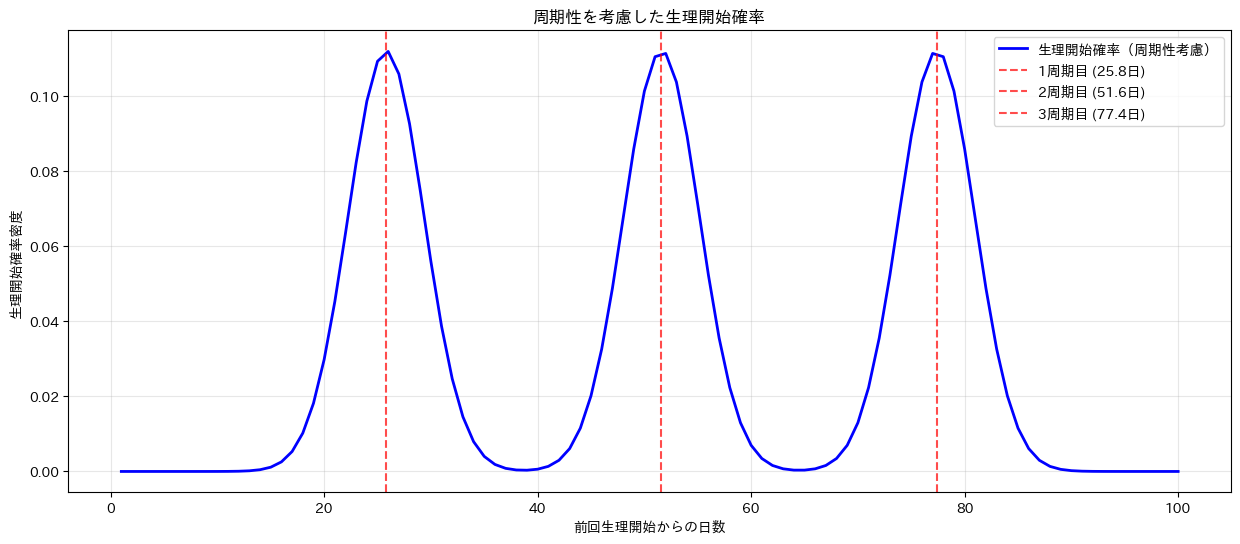

In [5]:
# 周期性の確認用グラフ
def plot_cyclic_probability(mean_cycle, std_cycle, max_days=100):
    """周期的な生理開始確率をプロット"""
    days = np.arange(1, max_days + 1)
    probs = [calculate_menstrual_probability_cyclic(day, mean_cycle, std_cycle) for day in days]
    
    plt.figure(figsize=(15, 6))
    plt.plot(days, probs, 'b-', linewidth=2, label='生理開始確率（周期性考慮）')
    
    # 予想される生理開始日をマーク
    for cycle in range(1, 4):
        expected_day = cycle * mean_cycle
        plt.axvline(x=expected_day, color='red', linestyle='--', alpha=0.7, 
                   label=f'{cycle}周期目 ({expected_day:.1f}日)')
    
    plt.xlabel('前回生理開始からの日数')
    plt.ylabel('生理開始確率密度')
    plt.title('周期性を考慮した生理開始確率')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# 周期性グラフの表示
plot_cyclic_probability(mean_cycle, std_cycle)

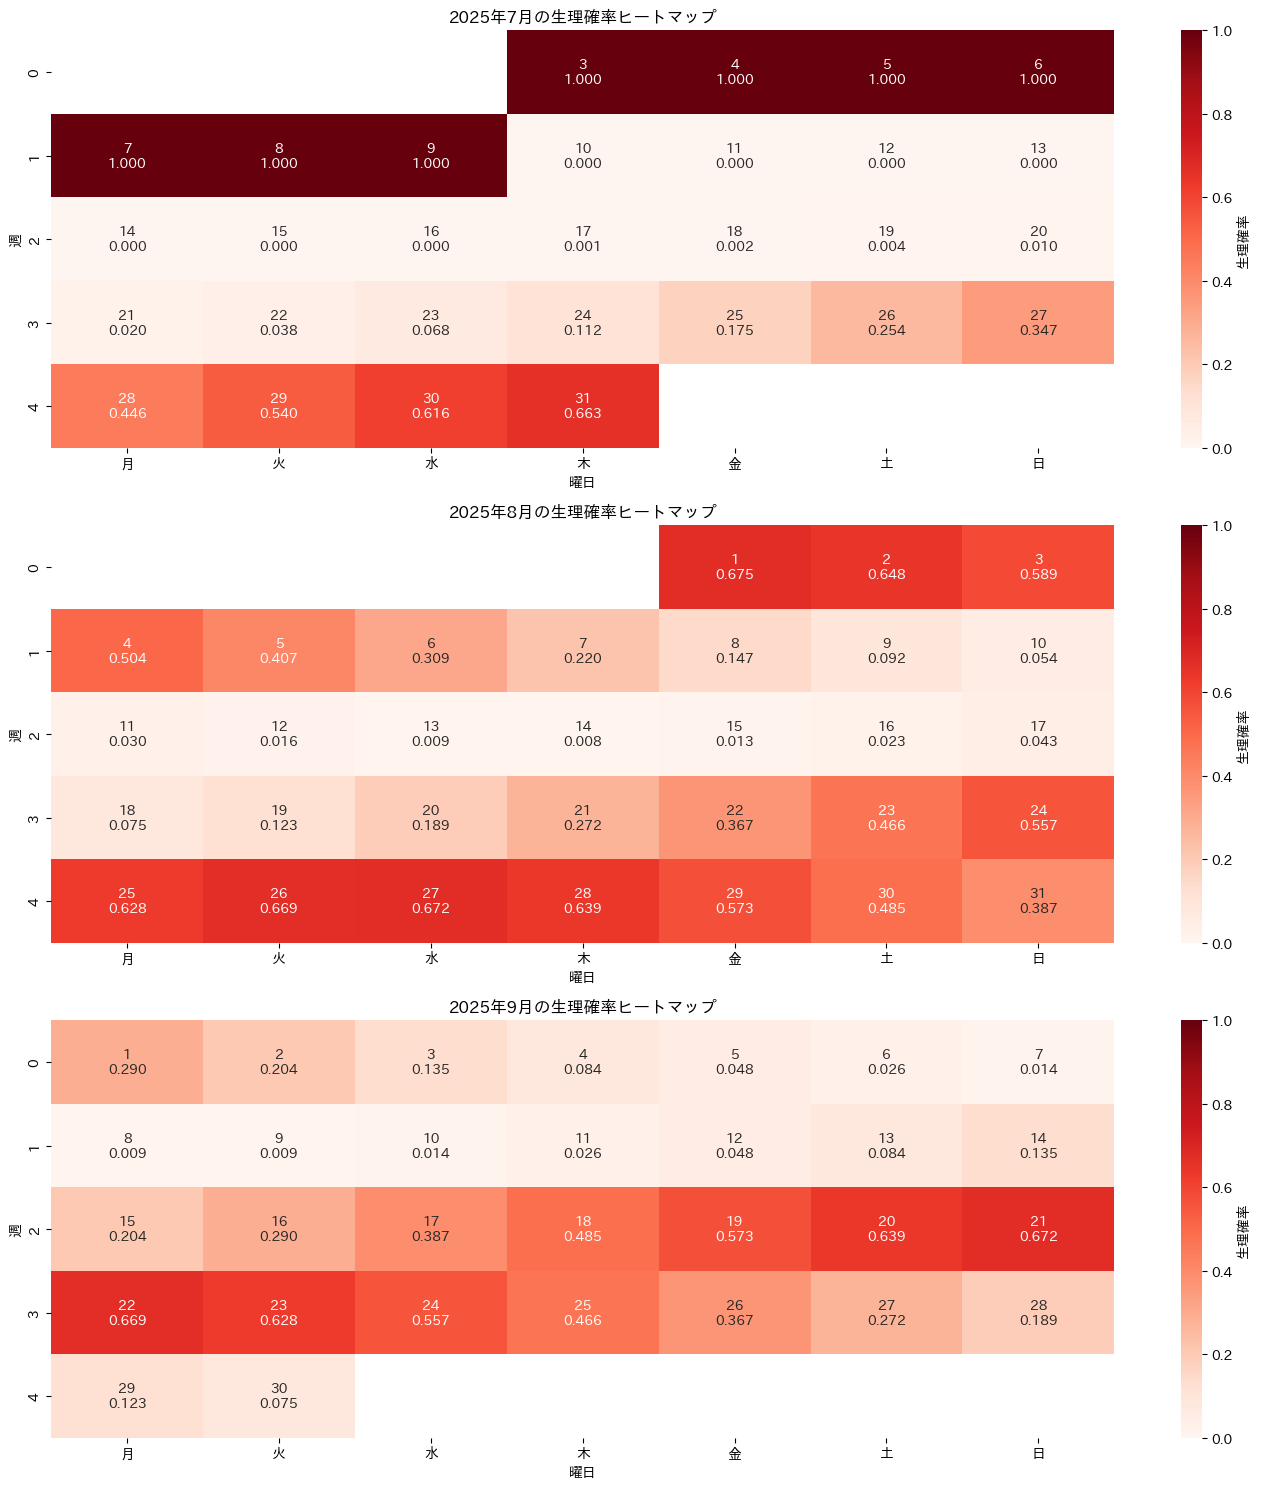

In [6]:
# カレンダー形式でのヒートマップ作成（日にち表示付き）
def create_calendar_heatmap(df):
    """カレンダー形式のヒートマップを作成（日にち表示付き）"""
    # 年月日を分離
    df_copy = df.copy()
    df_copy['year'] = df_copy['date'].dt.year
    df_copy['month'] = df_copy['date'].dt.month
    df_copy['day'] = df_copy['date'].dt.day
    df_copy['weekday'] = df_copy['date'].dt.dayofweek  # 0=月曜日, 6=日曜日
    
    # 月ごとにヒートマップを作成
    months = sorted(df_copy['month'].unique())
    fig, axes = plt.subplots(len(months), 1, figsize=(14, 5*len(months)))
    
    if len(months) == 1:
        axes = [axes]
    
    for i, month in enumerate(months):
        month_data = df_copy[df_copy['month'] == month].copy()
        
        # 月の最初の日の曜日を取得
        first_day = datetime(month_data['year'].iloc[0], month, 1)
        first_weekday = first_day.weekday()
        
        # 週番号を計算（月の最初の週から）
        month_data['week_of_month'] = ((month_data['day'] - 1 + first_weekday) // 7)
        
        # 確率のピボットテーブルを作成
        pivot_table = month_data.pivot_table(
            values='probability', 
            index='week_of_month', 
            columns='weekday', 
            fill_value=np.nan
        )
        
        # 日にちのピボットテーブルを作成
        day_pivot_table = month_data.pivot_table(
            values='day', 
            index='week_of_month', 
            columns='weekday', 
            fill_value=np.nan
        )
        
        # カスタムアノテーションを作成（日にち + 確率）
        annot_array = np.full(pivot_table.shape, '', dtype=object)
        for row in range(pivot_table.shape[0]):
            for col in range(pivot_table.shape[1]):
                if not np.isnan(pivot_table.iloc[row, col]):
                    day_val = int(day_pivot_table.iloc[row, col])
                    prob_val = pivot_table.iloc[row, col]
                    annot_array[row, col] = f'{day_val}\n{prob_val:.3f}'
        
        # ヒートマップを描画
        sns.heatmap(
            pivot_table, 
            annot=annot_array, 
            fmt='', 
            cmap='Reds', 
            ax=axes[i],
            cbar_kws={'label': '生理確率'},
            xticklabels=['月', '火', '水', '木', '金', '土', '日'],
            mask=pivot_table.isna(),
            annot_kws={'fontsize': 10},
            vmin=0,
            vmax=1
        )
        
        axes[i].set_title(f'{month_data["year"].iloc[0]}年{month}月の生理確率ヒートマップ')
        axes[i].set_xlabel('曜日')
        axes[i].set_ylabel('週')
    
    plt.tight_layout()
    plt.show()

# ヒートマップの作成
create_calendar_heatmap(df)